In [1]:
!python3 --version
!pip install --upgrade pip --quiet && echo $?
!pip install --upgrade diffusers accelerate transformers --quiet && echo $?
!pip install diffusers["torch"] ipywidgets --quiet && echo $?
!pip list | grep -e diffusers -e torch -e transformers

Python 3.10.9
0
0
0
diffusers                0.16.1
torch                    2.0.0
transformers             4.28.1


In [6]:
import diffusers
import torch

from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16, 
    revision="fp16"
).to("cuda")

Fetching 15 files:   0%|                                                                                                                   | 0/15 [00:00<?, ?it/s]




































































































Fetching 15 files:  27%|████████████████████████████▌                                                                              | 4/15 [00:01<00:04,  2.29it/s]























Fetching 15 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.49it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.pyenv/versions/py309/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.57it/s]


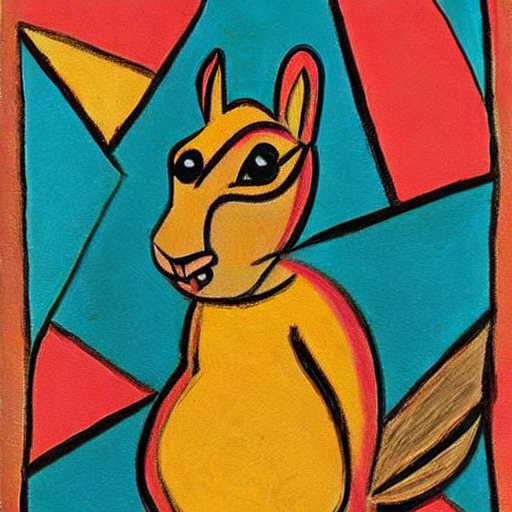

In [8]:
image = pipeline("An image of a squirrel in Picasso style").images[0]
image

In [9]:
image.save("image_of_squirrel_painting.png")

In [12]:
# swapping schedulers
from diffusers import EulerDiscreteScheduler

pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.27it/s]


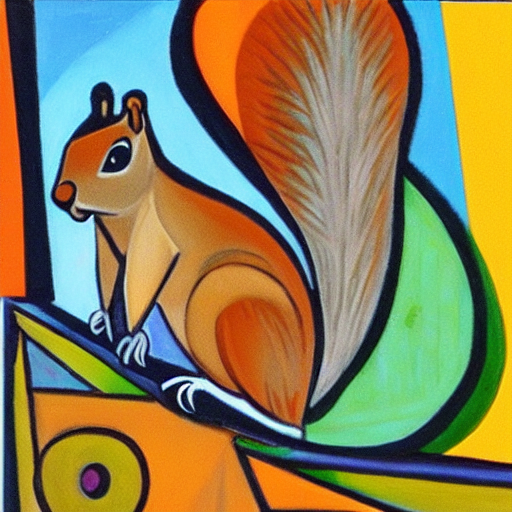

In [13]:
image = pipeline("An image of a squirrel in Picasso style").images[0]
image

In [14]:
# Model
from diffusers import UNet2DModel

repo_id = "google/ddpm-cat-256"
model = UNet2DModel.from_pretrained(repo_id)

In [15]:
model.config

"""
sample_size: the height and width dimension of the input sample.
in_channels: the number of input channels of the input sample.
down_block_types and up_block_types: the type of down- and upsampling blocks used to create the UNet architecture.
block_out_channels: the number of output channels of the downsampling blocks; also used in reverse order for the number of input channels of the upsampling blocks.
layers_per_block: the number of ResNet blocks present in each UNet block.
"""

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [16]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
noisy_sample.shape

with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

In [17]:
# Schedulers
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)
scheduler

/home/ubuntu/.pyenv/versions/py309/lib/python3.10/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "thresholding": false,
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [18]:
less_noisy_sample = scheduler.step(model_output=noisy_residual, timestep=2, sample=noisy_sample).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [19]:
import PIL.Image
import numpy as np


def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

  5%|██████                                                                                                                     | 49/1000 [00:05<01:48,  8.79it/s]

'Image at step 50'

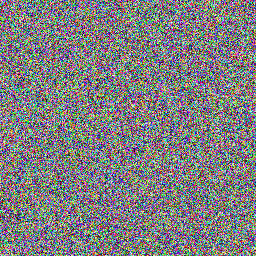

 10%|████████████▏                                                                                                              | 99/1000 [00:11<01:43,  8.71it/s]

'Image at step 100'

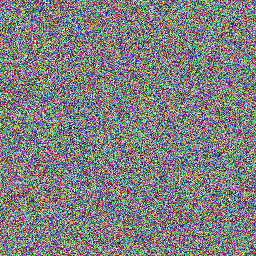

 15%|██████████████████▏                                                                                                       | 149/1000 [00:17<01:38,  8.67it/s]

'Image at step 150'

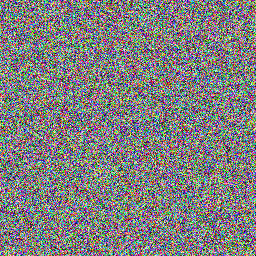

 20%|████████████████████████▎                                                                                                 | 199/1000 [00:22<01:32,  8.66it/s]

'Image at step 200'

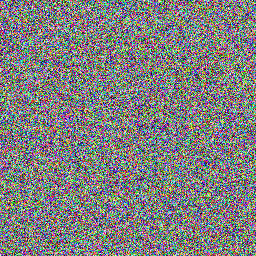

 25%|██████████████████████████████▍                                                                                           | 249/1000 [00:28<01:26,  8.64it/s]

'Image at step 250'

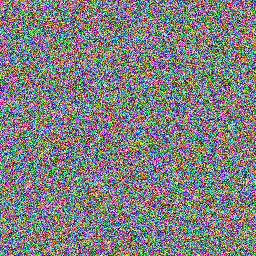

 30%|████████████████████████████████████▍                                                                                     | 299/1000 [00:34<01:21,  8.62it/s]

'Image at step 300'

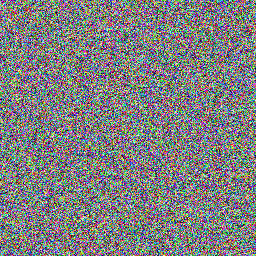

 35%|██████████████████████████████████████████▌                                                                               | 349/1000 [00:40<01:15,  8.60it/s]

'Image at step 350'

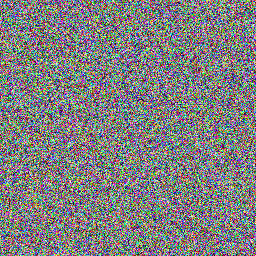

 40%|████████████████████████████████████████████████▋                                                                         | 399/1000 [00:46<01:10,  8.58it/s]

'Image at step 400'

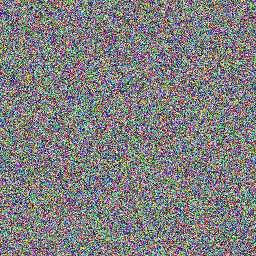

 45%|██████████████████████████████████████████████████████▊                                                                   | 449/1000 [00:51<01:04,  8.53it/s]

'Image at step 450'

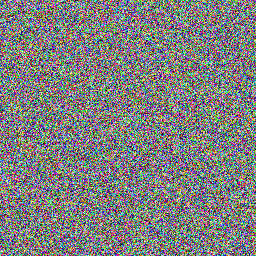

 50%|████████████████████████████████████████████████████████████▉                                                             | 499/1000 [00:57<00:58,  8.50it/s]

'Image at step 500'

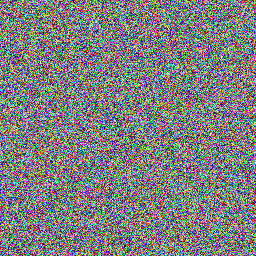

 55%|██████████████████████████████████████████████████████████████████▉                                                       | 549/1000 [01:03<00:53,  8.50it/s]

'Image at step 550'

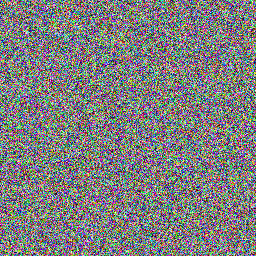

 60%|█████████████████████████████████████████████████████████████████████████                                                 | 599/1000 [01:09<00:47,  8.47it/s]

'Image at step 600'

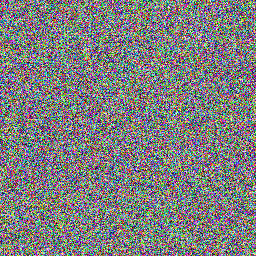

 65%|███████████████████████████████████████████████████████████████████████████████▏                                          | 649/1000 [01:15<00:41,  8.46it/s]

'Image at step 650'

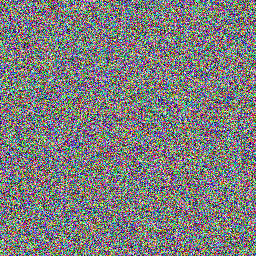

 70%|█████████████████████████████████████████████████████████████████████████████████████▎                                    | 699/1000 [01:21<00:35,  8.44it/s]

'Image at step 700'

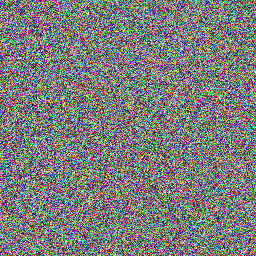

 75%|███████████████████████████████████████████████████████████████████████████████████████████▍                              | 749/1000 [01:27<00:29,  8.42it/s]

'Image at step 750'

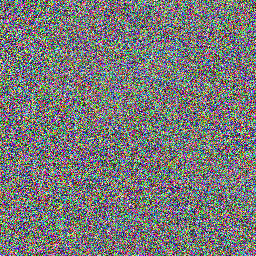

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 799/1000 [01:33<00:23,  8.42it/s]

'Image at step 800'

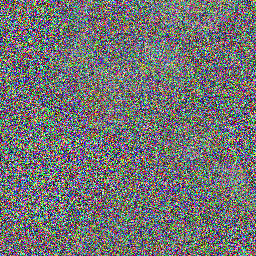

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 849/1000 [01:39<00:17,  8.40it/s]

'Image at step 850'

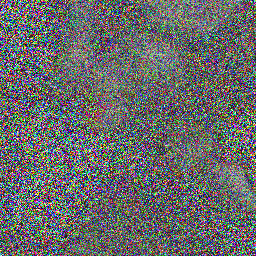

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 899/1000 [01:45<00:12,  8.35it/s]

'Image at step 900'

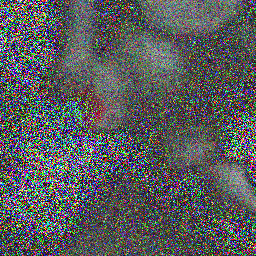

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 949/1000 [01:51<00:06,  8.35it/s]

'Image at step 950'

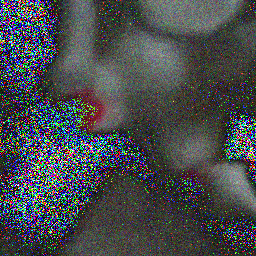

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:57<00:00,  8.35it/s]

'Image at step 1000'

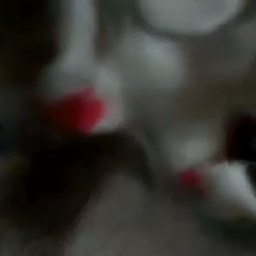

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.51it/s]


In [20]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 50 == 0:
        display_sample(sample, i + 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.23it/s]


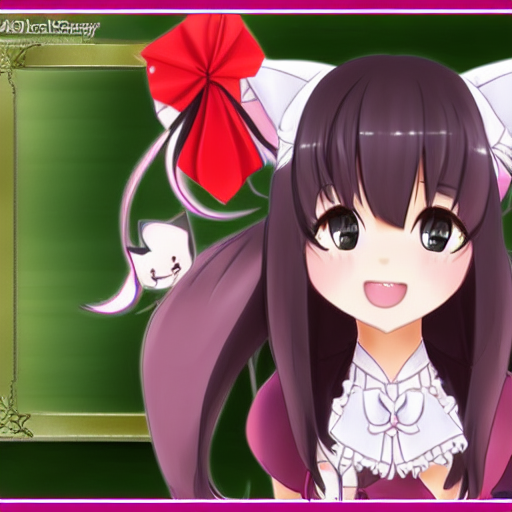

In [22]:
prompt = "cute cat ear maid"
image = pipeline(prompt).images[0]
image